# Generative Adversarial Network with Pytorch

ref: https://developers.google.com/machine-learning/gan

###0. What are GANs?
GANs are generative models: they create new data instances that resemble the training data. 
GANs achieve high level of realism by pairing with: 

1. generator:
  - learns to produce the target output by generating new augmented data.
  - capture the joint probability p(X, Y), or just p(X) if there are no labels.
  - tries to fool the discriminator
2.  discriminator : 
  - learns to distinguish true data from the output of the generator. 
  -  capture the conditional probability p(Y | X).
  -  tries to keep from being fooled.
-  **Generative** models 
  -  if generator training goes well, the discriminator gets worse at telling the difference between real and fake.

    -> starts to classify fake data as real
    -> accuracy decreases, greater loss.
  - hard to train: they have to capture most featuers, compared to discriminative models where they only have to recognise patterns.

- **Discriminator**
  - training data: 
    - +ve example = real data
    - -ve exmaple = fake data

  - loss function
    - connects to two loss functions
    -  ignores generator loss, just uses discriminator loss

### 1. format

General format for GAN: 

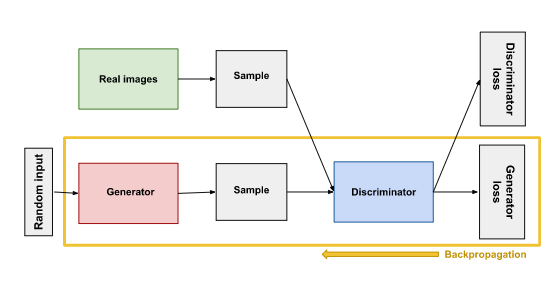

2 iterations.

- per iteration of generator training: 

  1. Sample random noise.
  2. Produce generator output from sampled random noise.
  3. Get discriminator "Real" or "Fake" classification for generator output.
  4. Calculate loss from discriminator classification.
  5. Backpropagate through both the discriminator and generator to obtain gradients.
  6. Use gradients to change only the generator weights.

- GAN training : alternating training
  - keep generator constant during the discriminator training phase, vice versa

### 2. Implementation


### 2.1 Configurations

In [3]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm # progress bar

device = 'cuda' # transfer image output to gpu : image = image.to(device)

batch_size = 128 # for trainloader, training loop
noise_dim = 64 # for generator model init

# parameters, training variables
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.5
epochs = 20 # no. of runs

### 2.2 Load MNIST Dataset 

total inages present in trainset =  60000


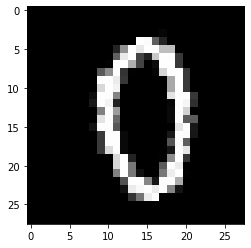

In [9]:
from torchvision import datasets, transforms as T

# transform dataset images
train_augs = T.Compose([T.RandomRotation((-20, +20)),
                        T.ToTensor() # convert PT (h,w,c) to TF format (b,c,h,w)
                        ])
# import training set 
trainset = datasets.MNIST('MNIST/', download = True, 
                          train = True, # use training set 
                          transform = train_augs) # transform input 

# look at trainset 
image, label = trainset[1000] 
plt.imshow(image.squeeze(), cmap = 'gray') # reduce dim (1,28,28) , colour maps

print('total inages present in trainset = ', len(trainset)) # 60000

### 2.2 Load Dataset Into Batches 

In [8]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [10]:
# dividing batches and shuffling
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True) 

print('total number of batches in trainloader =' , len(trainloader)) # 469 batches


total number of batches in trainloader = 469


In [21]:
dataiter = iter(trainloader) # return an iterator
images, _ = dataiter.next() # next: get first iteration / batch

print(images.shape) # 1 batch = 128 images


torch.Size([128, 1, 28, 28])


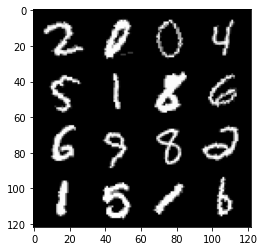

In [22]:
# 'show_tensor_images' : plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

show_tensor_images(images, num_images = 16)

### 2.3 Create Discriminator Network 

Goal: binary classifier of whether it is fake / real image. 

In [73]:
#In case if torch summary is not installed 
from torch import nn
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [75]:
def get_disc_block(in_channels, out_channels, kernel_size, stride): 
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [76]:
class Discriminator(nn.Module): 

  def __init__(self):
    super(Discriminator,self).__init__()

    self.block_1 = get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self, images): 
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    
    x4 = self.flatten(x3)
    x5 = self.linear(x4)
    
    return x5


In [77]:
D = Discriminator()
D.to(device)

summary(D, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

### 2.4 Create Generator Network 
we create augmented images for input to discriminator network.

In [78]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                               

In [79]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [80]:
# network

class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator,self).__init__()
    
    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)

    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

  def forward(self, r_noise_vec):
    #(bs, noise_dim) to (bs, noise_dim, 1, 1)
    x = r_noise_vec.view(-1, self.noise_dim, 1, 1)
    
    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)
    return x4



In [81]:
G = Generator(noise_dim)

G.to(device)
summary(G,input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [82]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

# weights for discriminator and generator
D = D.apply(weights_init)
G = G.apply(weights_init)

### 2.5 Create Loss Function and Load Optimizer
GANs try to replicate a probability distribution. They should therefore use loss functions that reflect the distance between the distribution of the data generated by the GAN and the distribution of the real data.

Some common loss function

- minimax loss: The loss function used in the paper that introduced GANs.
- Wasserstein loss: The default loss function for TF-GAN Estimators. First described in a 2017 paper.
- BCE logit loss = binary cross entropy loss


In [83]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

# optimisers
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))

### 2.6 Training Loop 

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.6823290629681747 | G_loss : 0.6982148348141327


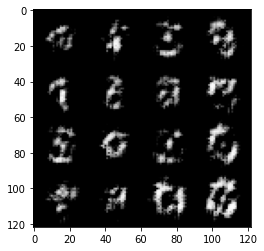

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.6824524533519867 | G_loss : 0.7060868440152231


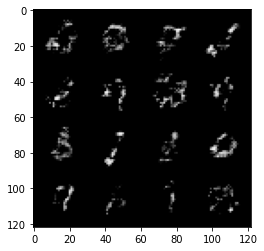

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.6574336718648736 | G_loss : 0.736675940596981


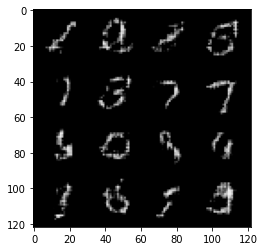

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.6220006701280313 | G_loss : 0.7775484202767232


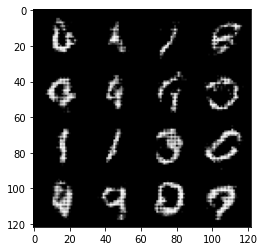

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.6287597885518186 | G_loss : 0.7782274544366133


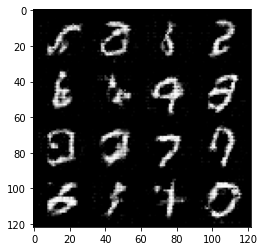

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.63725342425202 | G_loss : 0.7812679877667539


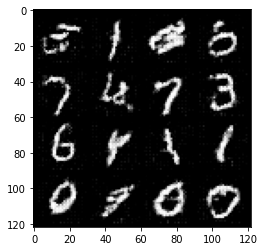

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.6458808713630318 | G_loss : 0.7759502151373353


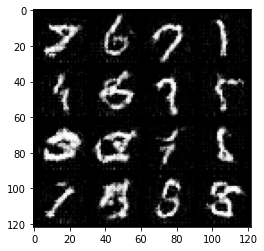

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.6545770855854823 | G_loss : 0.7669496595986617


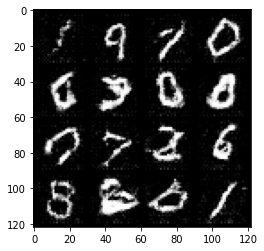

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.6579774616877916 | G_loss : 0.7628687798087277


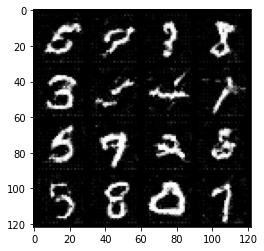

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_loss : 0.6508557670660364 | G_loss : 0.7750935356245875


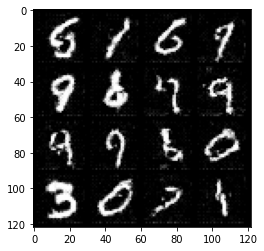

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_loss : 0.6542604723210528 | G_loss : 0.7712839488535802


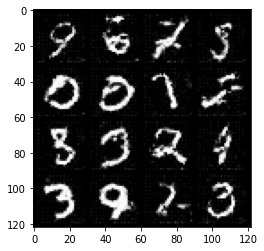

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_loss : 0.6581868245911751 | G_loss : 0.7682598794955434


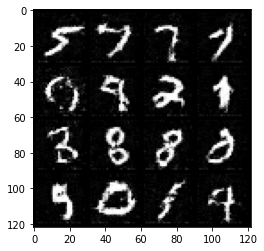

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_loss : 0.6584852898298804 | G_loss : 0.766466695998015


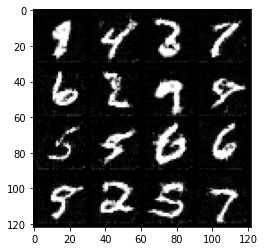

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_loss : 0.6608487080409329 | G_loss : 0.7638061956556113


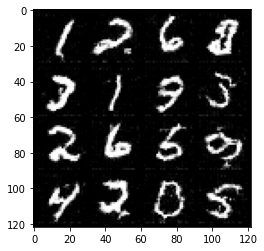

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_loss : 0.6634481640766933 | G_loss : 0.763384457717318


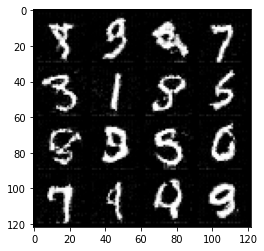

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_loss : 0.6637322407033144 | G_loss : 0.7621821553976551


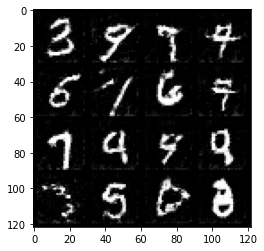

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_loss : 0.6643266968889785 | G_loss : 0.7633091274863367


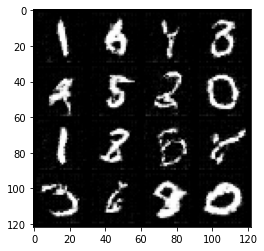

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_loss : 0.6652675436249674 | G_loss : 0.7642364587102618


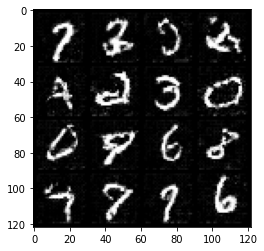

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_loss : 0.6647976444982516 | G_loss : 0.7626442934658482


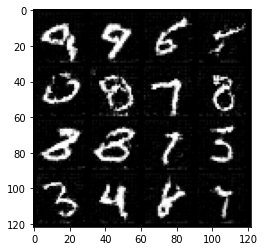

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_loss : 0.6665582621275489 | G_loss : 0.7605030719659476


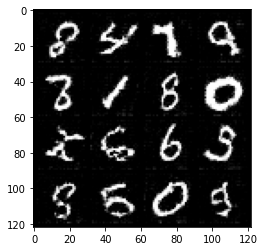

In [84]:
for i in range(epochs):

  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):

    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)
    
    # find loss, update weights for D

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/ 2
    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    # find loss, update for generative network

    G_opt.zero_grad()   

    noise = torch.randn(batch_size, noise_dim, device = device)
    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss /len(trainloader)
  avg_g_loss = total_g_loss /len(trainloader)

  print('Epoch : {} | D_loss : {} | G_loss : {}'.format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img) # h

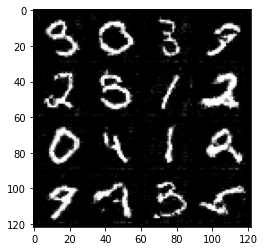

In [85]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya